In [1]:
import ete2
import skbio
import numpy as np
import matplotlib.pyplot as plt

%pylab inline

No module named MySQLdb
No module named PyQt4.QtGui
Populating the interactive namespace from numpy and matplotlib


 MySQLdb module could not be loaded
Treeview module could not be loaded


## Load a tree

In [2]:
# it'd be nice if this expandvars call happened interally
from os.path import expandvars
et = ete2.Tree(expandvars('$HOME/data/gg_13_8_otus/trees/85_otus.tree'))
st = skbio.TreeNode.read(expandvars('$HOME/data/gg_13_8_otus/trees/85_otus.tree'))

## repr the tree

In [3]:
et

Tree node 'NoName' (0x115714b1)

In [4]:
st

<TreeNode, name: unnamed, internal node count: 5086, tips count: 5088>

In [5]:
print et


                        /-4479984
                       |
                       |               /-540377
                       |            /-|
                       |         /-|   \-811993
                       |        |  |
                       |        |   \-823988
                       |      /-|
                     /-|     |  |      /-4397176
                    |  |     |  |   /-|
                    |  |     |   \-|   \-4446470
                    |  |   /-|     |
                    |  |  |  |      \-3618039
                    |  |  |  |
                    |  |  |  |   /-2384822
                    |  |  |   \-|
                    |  |  |     |   /-281379
                    |   \-|      \-|
                    |     |        |   /-661986
                    |     |         \-|
                    |     |           |   /-553287
                    |     |            \-|
                    |     |               \-1106961
                    |     |
               

In [6]:
et.describe()

Number of leaf nodes:	5088
Number of internal nodes:	10175
Rooted:	Yes
Most distant node:	4438147
Max. distance:	6.927510


In [7]:
print st

((((((((4479984:0.18333,(((((540377:0.03714,811993:0.03772):0.06444,823988:0.10187)0.382:0.02055,((4397176:0.13216,4446470:0.04374)0.749:0.01051,3618039:0.09491)0.378:0.00638)0.989:0.03318,(2384822:0.09073,(281379:0.13676,(661986:0.10672,(553287:0.02573,1106961:0.0293):0.0558)0.329:0.01409)0.991:0.02839)0.851:0.0257)0.964:0.03174,698544:0.13414)'o__HydGC-84-221A':0.06393)0.951:0.02374,((((((2724974:0.10288,4397177:0.16572)0.482:0.02907,4403061:0.14296)0.189:0.01071,(606667:0.07166,4354130:0.09777)0.992:0.03339)0.968:0.02329,(21:0.09236,247740:0.09214):0.02136)'0.998:o__DHVE3':0.03361,(200279:0.13132,((((4372908:0.09734,((1940940:0.0498,811277:0.05482)0.561:0.01434,823117:0.06908)0.993:0.03825)0.994:0.04033,((4371796:0.05527,4373917:0.16352)0.842:0.03811,4374783:0.14307)0.606:0.01899):0.05828,((119396:0.08156,((517082:0.07483,(771867:0.02666,823009:0.05074)0.999:0.05797)0.845:0.02769,813376:0.06403):0.03046)0.983:0.02924,(568498:0.16255,3618038:0.14732)0.48:0.02042)0.965:0.01928)0.996:0

## Traversing the tree and time it

In [8]:
%%timeit 
# load the tree on each loop to avoid caching of results
ete2.Tree(expandvars('$HOME/data/gg_13_8_otus/trees/85_otus.tree')).traverse("postorder")

10 loops, best of 3: 98.3 ms per loop


In [9]:
%%timeit 
# load the tree on each loop to avoid caching of results
skbio.TreeNode.read(expandvars('$HOME/data/gg_13_8_otus/trees/85_otus.tree')).postorder()

10 loops, best of 3: 106 ms per loop


## Implement and compute PD

Phylogenetic Diversity (PD) is the amount of branch length in a phylogenetic tree that is observed in a given biological community. It is a phylogenetic estimator of community richness. I describe it in some more detail in [IAB](http://nbviewer.ipython.org/github/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/blob/0.1.0/applications/biological-diversity.ipynb#Phylogenetic-Diversity-(PD)).

In [10]:
from random import shuffle
tip_names = [t.name for t in st.tips()]
shuffle(tip_names)
observed_tips = tip_names[:500]

In [11]:
%timeit et.get_leaves_by_name('139526')[0]

10 loops, best of 3: 18.5 ms per loop


In [12]:
%timeit st.find('139526')

The slowest run took 5823.83 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.51 µs per loop


In [13]:
%timeit et.get_leaves_by_name('139526')[0].get_ancestors()

100 loops, best of 3: 17.9 ms per loop


In [14]:
%timeit st.find('139526').ancestors()

The slowest run took 4.70 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 11.3 µs per loop


2289
358.32967


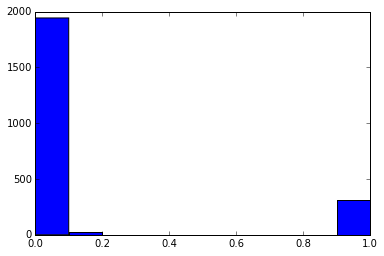

In [15]:
def et_pd(tree, observed_tips):
    observed_nodes = set()
    for tip_name in observed_tips:
        observed_nodes |= set(tree.get_leaves_by_name(tip_name)[0].get_ancestors())
    pd = sum([o.dist for o in observed_nodes])
    ds = [(o.dist, o.name) for o in observed_nodes]
    ds.sort()
    print len(ds)
    return ds, pd
ds, pd = et_pd(et, observed_tips)
print pd
_ = plt.hist([e[0] for e in ds])

2287
50.51351


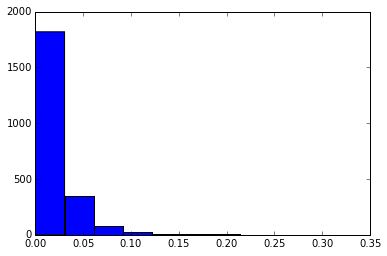

In [16]:
def sk_pd(tree, observed_tips):
    observed_nodes = set()
    for tip_name in observed_tips:
        observed_nodes |= set(tree.find(tip_name).ancestors())
    pd = sum([o.length for o in observed_nodes if o.length != None])
    ds = [(o.length, o.name) for o in observed_nodes if o.length != None]
    print len(ds)
    return ds, pd
ds, pd = sk_pd(st, observed_tips)
print pd
_ = plt.hist([e[0] for e in ds])

**Question**: where are all of the branch lengths of 1.0 coming from in the ete2 tree??